In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection,linear_model, metrics
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
X_raw = df.drop(["mpg"],axis=1)
y_raw = df[["mpg"]]
train, test = model_selection.train_test_split(df, test_size=0.2, random_state=42)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

In [4]:
def summarize_table(df):
    print('DataFrame has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    summary = pd.DataFrame(data=df.dtypes, columns=['dytpes'])
    summary.reset_index(inplace=True)
    summary['unique_values'] = df.nunique().values
    summary['missing_values'] = df.isnull().sum().values
    summary['missing_%'] = round(summary['missing_values'] / df.shape[0] * 100, 1)


    most_freq_1 = []
    most_freq_count_1 = []
    most_freq_2 = []
    most_freq_count_2 = []
    feat_entropy = []

    for col in df.columns:
        most_freq_1.append(df[col].value_counts().index[0])
        most_freq_count_1.append(df[col].value_counts().max())
        most_freq_2.append(df[col].value_counts().index[1])
        most_freq_count_2.append(df[col].value_counts().iloc[1:].max())
        feat_entropy.append(round(scipy.stats.entropy(df[col].value_counts(dropna=False, normalize=True), base=2), 2))

    summary['most_freq_value'] = most_freq_1
    summary['most_freq_value_count'] = most_freq_count_1
    summary['most_freq_value_count_%'] =  summary['most_freq_value_count']/df.shape[0]*100
    summary['2nd_most_freq_value'] = most_freq_2
    summary['2nd_most_freq_value_count'] = most_freq_count_2
    summary['2nd_most_freq_value_count_%'] = summary['2nd_most_freq_value_count']/df.shape[0]*100
    summary['feat_value_count_entropy'] = feat_entropy
    return summary

In [5]:
summarize_table(train)

DataFrame has 318 rows and 9 columns


,index,dytpes,unique_values,missing_values,missing_%,most_freq_value,most_freq_value_count,most_freq_value_count_%,2nd_most_freq_value,2nd_most_freq_value_count,2nd_most_freq_value_count_%,feat_value_count_entropy
0,mpg,float64,120,0,0.0,14,16,5.031447,13,16,5.031447,6.23
1,cylinders,int64,5,0,0.0,4,162,50.943396,8,79,24.842767,1.62
2,displacement,float64,78,0,0.0,97,18,5.660377,350,16,5.031447,5.67
3,horsepower,object,90,0,0.0,90,17,5.345912,150,16,5.031447,5.84
4,weight,int64,286,0,0.0,1985,4,1.257862,2155,3,0.943396,8.09
5,acceleration,float64,90,0,0.0,14.5,18,5.660377,15.5,14,4.402516,5.94
6,model year,int64,13,0,0.0,73,32,10.062893,78,31,9.748428,3.68
7,origin,int64,3,0,0.0,1,196,61.635220,3,66,20.754717,1.34
8,car name,object,246,0,0.0,toyota corolla,5,1.572327,amc matador,5,1.572327,7.78


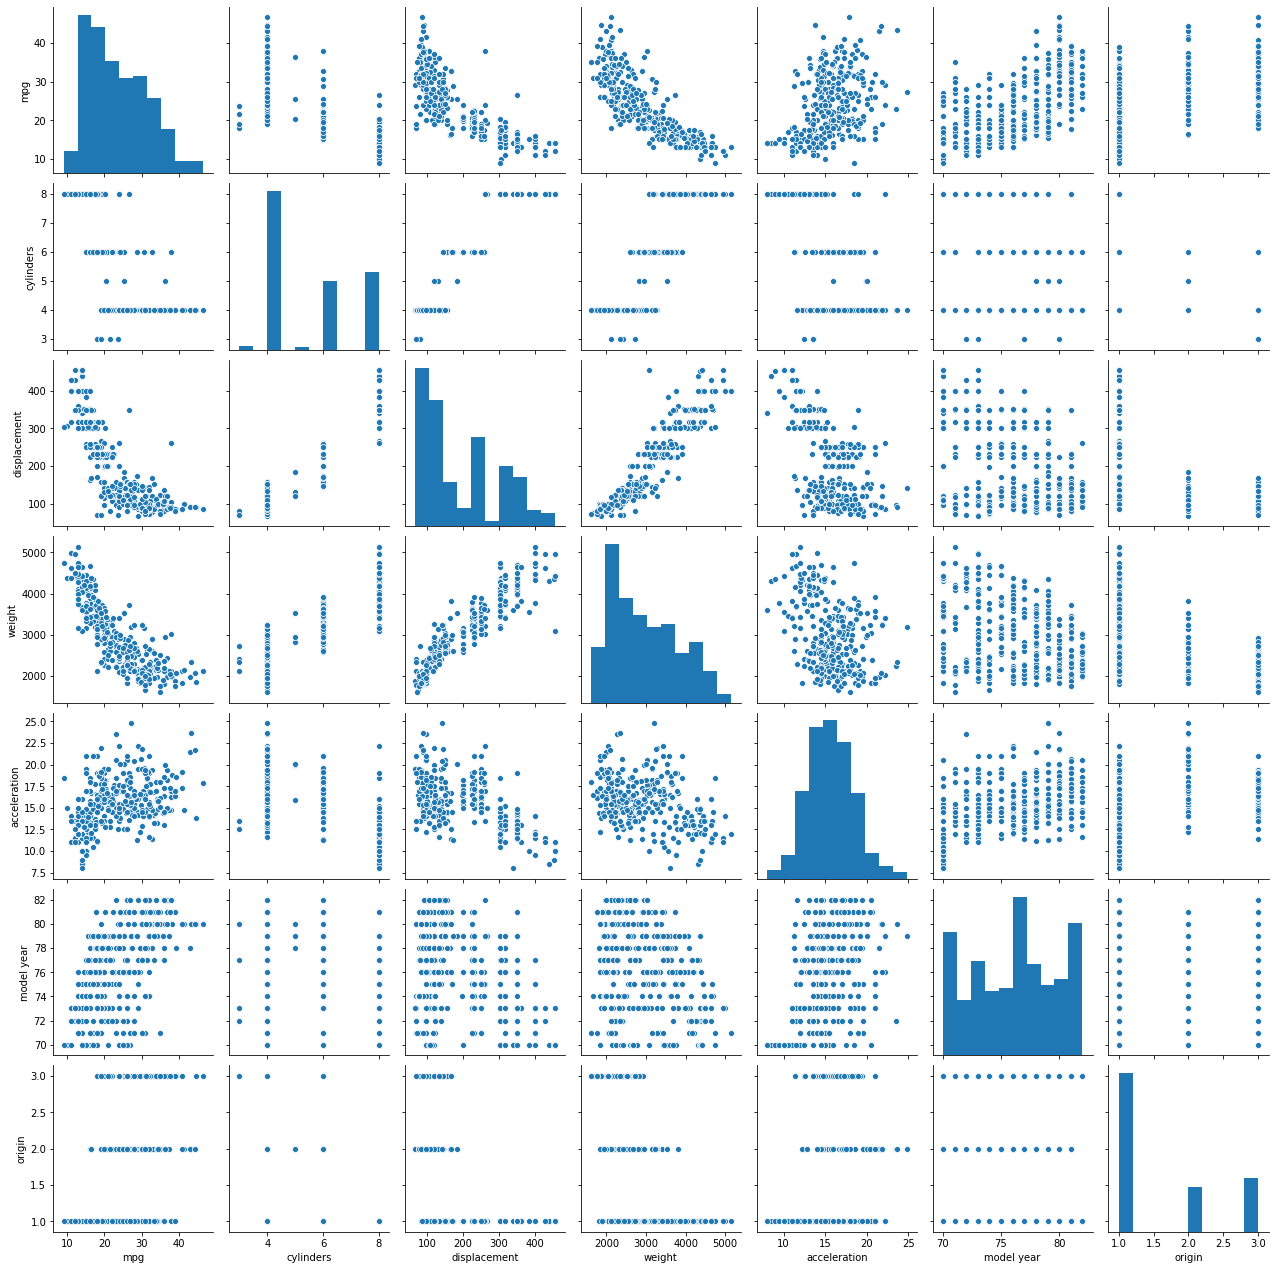

In [6]:
sns.pairplot(train)

# Preprocessing

In [7]:
X_train.drop(["car name"], axis=1, inplace=True)
X_test.drop(["car name"], axis =1, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
def transform_problamtic_feature_to_numerical(df, feature):
    tmp = df.copy()
    tmp[feature] = pd.to_numeric(tmp[feature], errors = "coerce")
    return tmp

X_train = transform_problamtic_feature_to_numerical(X_train, "horsepower")
    
cylinder_median_horsepower_dict = X_train.groupby(by=["cylinders"])["horsepower"].median().to_dict()    
X_train.loc[X_train["horsepower"].isnull(),"horsepower"] = X_train["cylinders"].map(cylinder_median_horsepower_dict)

cylinder_median_horsepower_dict

{3: 98.5, 4: 76.0, 5: 77.0, 6: 100.0, 8: 150.0}

In [9]:
X_test = transform_problamtic_feature_to_numerical(X_test, "horsepower")
X_test.loc[X_test["horsepower"].isnull(),"horsepower"] = X_test["cylinders"].map(cylinder_median_horsepower_dict)


# Modelling

In [10]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

8.193632515283596

In [11]:
xgb_model = XGBRegressor(seed=42)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

[13:03:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5.523847739487799

In [12]:
# grid search
lr = linear_model.LinearRegression()
grid_model = model_selection.GridSearchCV(lr, param_grid={},cv = 5,scoring="neg_mean_squared_error")
grid_model.fit(X_train,y_train)
grid_model.cv_results_

{'mean_fit_time': array([0.0042078]),
 'std_fit_time': array([0.000894]),
 'mean_score_time': array([0.00189376]),
 'std_score_time': array([0.00057448]),
 'params': [{}],
 'split0_test_score': array([-10.36228039]),
 'split1_test_score': array([-10.75090573]),
 'split2_test_score': array([-13.0522828]),
 'split3_test_score': array([-14.13206105]),
 'split4_test_score': array([-13.16762152]),
 'mean_test_score': array([-12.2930303]),
 'std_test_score': array([1.47168962]),
 'rank_test_score': array([1], dtype=int32)}

In [13]:
pred = grid_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

8.193632515283596

In [24]:
# grid search
xgb_model = XGBRegressor(seed=42)
grid_model = model_selection.GridSearchCV(xgb_model, param_grid={"max_depth":[6]},cv = 5,scoring="neg_mean_squared_error")
grid_model.fit(X_train,y_train)
grid_model.cv_results_

[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'mean_fit_time': array([0.04179821]),
 'std_fit_time': array([0.00671584]),
 'mean_score_time': array([0.00176468]),
 'std_score_time': array([0.00014356]),
 'param_max_depth': masked_array(data=[6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 6}],
 'split0_test_score': array([-7.95672689]),
 'split1_test_score': array([-8.76599603]),
 'split2_test_score': array([-12.45894996]),
 'split3_test_score': array([-14.37588213]),
 'split4_test_score': array([-7.30471474]),
 'mean_test_score': array([-10.17245395]),
 'std_test_score': array([2.75711338]),
 'rank_test_score': array([1], dtype=int32)}

In [25]:
grid_model.best_params_

{'max_depth': 6}

In [26]:
pred = grid_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

7.5388447359415025